In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.special import zeta
from scipy.stats import gamma
from scipy.integrate import quad
import pcms.tree

In [2]:
GAMMA = 0.57721566490153286060651209008240243

## Part 1: Verify functionality

In [3]:
tree = pcms.tree.cbst(n_leaves=10)
tree.print(label='index')

└── 18
    ├── 16
    │   ├── 0
    │   └── 15
    │       ├── 5
    │       │   ├── 1
    │       │   └── 4
    │       │       ├── 2
    │       │       └── 3
    │       └── 14
    │           ├── 6
    │           └── 13
    │               ├── 11
    │               │   ├── 7
    │               │   └── 10
    │               │       ├── 8
    │               │       └── 9
    │               └── 12
    └── 17


### Compute the exact value of $\mathbb{E}[\mathrm{L}_n]$

In [4]:
def integrand(x, n):
    return (1 - x**n) / (1 - x)

def harmonic_number(n):
    hn, _ = quad(integrand, 0, 1, args=(n,))
    return hn

In [5]:
ln_cache = {1: 0}

def exp_ln_exact(n):
    if n in ln_cache:
        return ln_cache[n]

    s = np.sum([exp_ln_exact(i) / (n-i) for i in range(1,n)])
    ln_cache[n] = 1 + s / harmonic_number(n-1)
    return ln_cache[n]

### Draw samples of $\mathrm{L}_n$ and compute the sample means

In [ ]:
def draw_ln(n_samples, n_leaves):
    depths = []
    for _ in range(n_samples):
        tree = pcms.tree.cbst(n_leaves=n_leaves)
        _, depths = tree.find_leaves(return_depths=True)
        depths.append(np.random.choice(depths))
    return np.array(depths)

In [7]:
N = 10000
Ns = np.arange(2, N, 50)
n_samples = 30

ln_means = []
for n_leaves in Ns:
    draw = draw_ln(n_samples=n_samples, n_leaves=n_leaves)
    ln_means.append(np.mean(draw))

In [8]:
ln_exacts = []
for n_leaves in Ns:
    ln_exacts.append(exp_ln_exact(n_leaves))

### First moment

In [9]:
A0 = 1/(2*zeta(2))
B0 = (GAMMA*zeta(2) + zeta(3))/(zeta(2)**2)
b0 = GAMMA**2/(2*zeta(2)) + GAMMA*zeta(3)/(zeta(2)**2) + zeta(3)**2/zeta(2)**3 + 1/10
ELn = lambda n: A0 * np.log(n)**2 + B0 * np.log(n) + b0

In [10]:
print(A0, B0, b0)

0.3039635509270133 0.795155660438793 0.7823442563696984


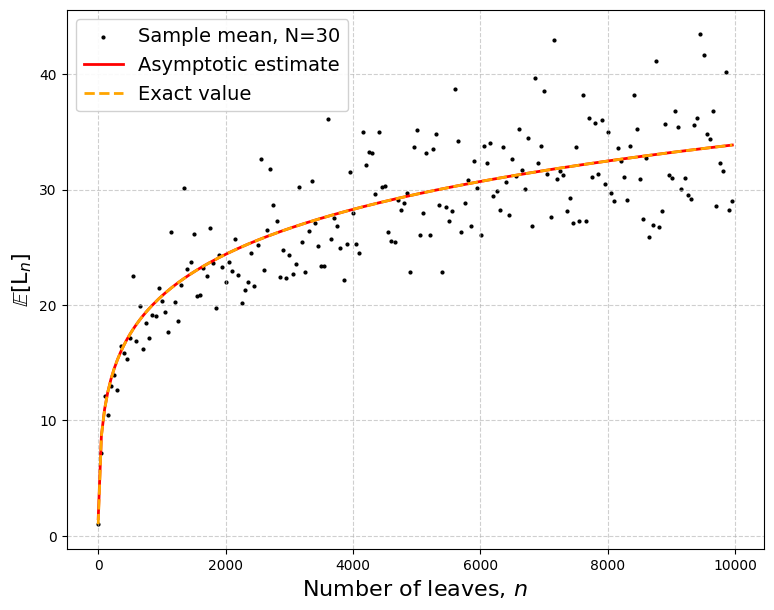

In [11]:
# Create the plot
fig, ax = plt.subplots(figsize=(9, 7))  # Larger figure size for readability

# Plot experimental and asymptotic estimates
ax.scatter(Ns, ln_means, label=f'Sample mean, N={n_samples}', color='black', s=4)
ax.plot(Ns, ELn(Ns), label='Asymptotic estimate', linestyle='-', color='red', linewidth=2)
ax.plot(Ns, ln_exacts, label='Exact value', linestyle='--', color='orange', linewidth=2)

# Title and axis labels
ax.set_xlabel(r'Number of leaves, $n$', fontsize=16)
ax.set_ylabel(r'$\mathbb{E}[\mathrm{L}_n]$', fontsize=16)

# Legend and grid
ax.legend(fontsize=14, loc='upper left', frameon=True, framealpha=0.9)
ax.grid(visible=True, linestyle='--', alpha=0.6)

# Improve tick formatt0125ing
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', length=4)

# Show the plot
plt.show()

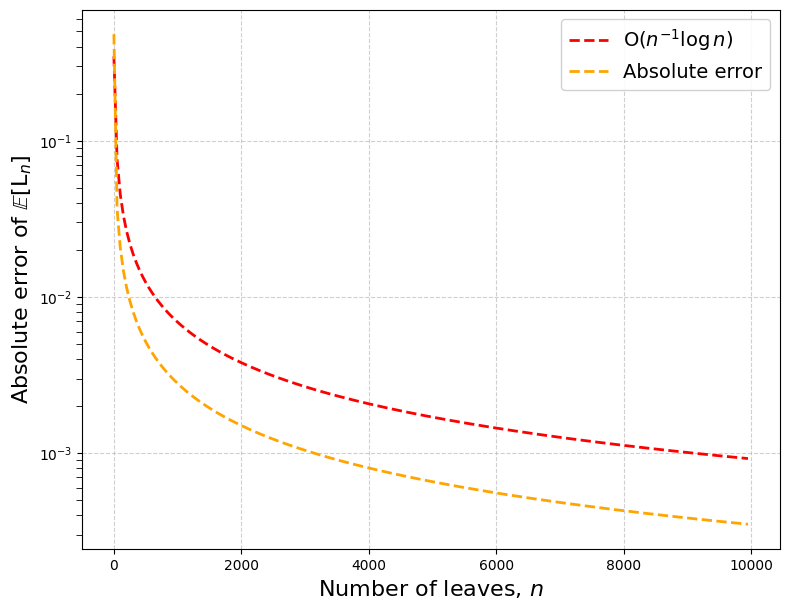

In [12]:
# Create the plot
fig, ax = plt.subplots(figsize=(9, 7))  # Larger figure size for readability

# Plot absolute error
ax.plot(Ns, np.log(Ns)/Ns, label=r'$\mathrm{O}(n^{-1}\log n)$', linestyle='--', color='red', linewidth=2)
ax.plot(Ns, np.abs(ln_exacts - ELn(Ns)), label='Absolute error', linestyle='--', color='orange', linewidth=2)

# Rescale y-axis
ax.set_yscale('log')

# Title and axis labels
ax.set_xlabel(r'Number of leaves, $n$', fontsize=16)
ax.set_ylabel(r'Absolute error of $\mathbb{E}[\mathrm{L}_n]$', fontsize=16)

# Legend and grid
ax.legend(fontsize=14, frameon=True, framealpha=0.9)
ax.grid(visible=True, linestyle='--', alpha=0.6)

# Improve tick formatt0125ing
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', length=4)

# Show the plot
plt.show()

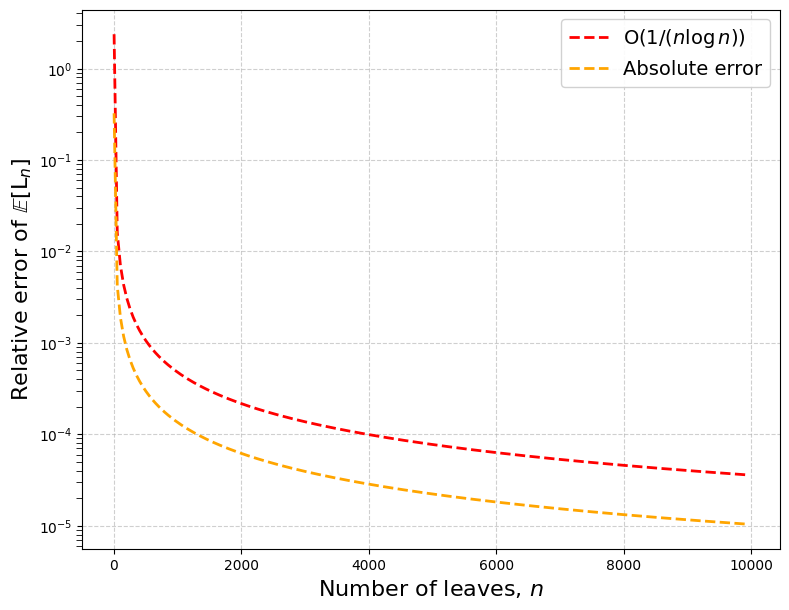

In [13]:
# Create the plot
fig, ax = plt.subplots(figsize=(9, 7))  # Larger figure size for readability

# Plot relative error
ax.plot(Ns, 1/(A0 * Ns * np.log(Ns)), label=r'$\mathrm{O}(1/(n\log n))$', linestyle='--', color='red', linewidth=2)
ax.plot(Ns, np.abs(ln_exacts - ELn(Ns)) / ELn(Ns), label='Absolute error', linestyle='--', color='orange', linewidth=2)

# Rescale y-axis
ax.set_yscale('log')

# Title and axis labels
ax.set_xlabel(r'Number of leaves, $n$', fontsize=16)
ax.set_ylabel(r'Relative error of $\mathbb{E}[\mathrm{L}_n]$', fontsize=16)

# Legend and grid
ax.legend(fontsize=14, frameon=True, framealpha=0.9)
ax.grid(visible=True, linestyle='--', alpha=0.6)

# Improve tick formatt0125ing
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', length=4)

# Show the plot
plt.show()

## Asymptotic approximations of the first two moments and variance of $\mathrm{EPL}(\mathrm{T}_n)$

In [14]:
def draw_epl(n_samples, n_leaves):
    epls = []
    for _ in range(n_samples):
        tree = pcms.tree.cbst(n_leaves=n_leaves)
        epls.append(tree.find_epl())
    return np.array(epls)

### Draw samples and compute sample moments and variance

In [147]:
N = 10000
Ns = np.arange(2, N, 50)
n_samples = 30
epl_means = []
epl_vars = []
epl_mean2s = []
for n_leaves in Ns:
    draw = draw_epl(n_samples=n_samples, n_leaves=n_leaves)
    epl_means.append(np.mean(draw))
    epl_vars.append(np.var(draw))
    epl_mean2s.append(np.mean(np.pow(draw,2)))

### An asymptotic estimate for the first moment of $\mathrm{EPL}(\mathrm{T}_n)$

In [148]:
epln_exacts = Ns * ln_exacts

In [149]:
A1 = 1 / (2 * zeta(2))
B1 = (GAMMA * zeta(2) + zeta(3)) / zeta(2)**2
EEPLn = lambda n: A1 * n * np.log(n)**2 + B1 * n * np.log(n) + b0 * n

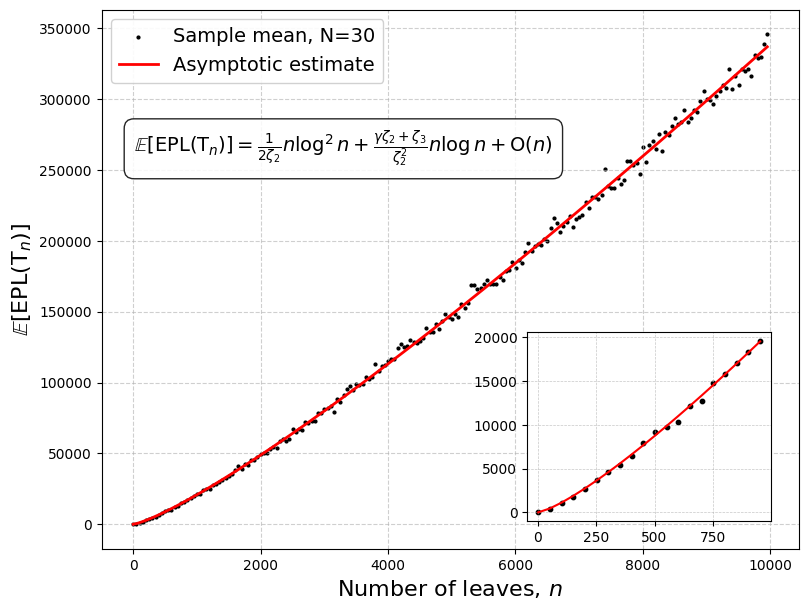

In [169]:
# Create the plot
fig, ax = plt.subplots(figsize=(9, 7))  # Larger figure size for readability

# Plot experimental and asymptotic estimates
ax.scatter(Ns, epl_means, label=f'Sample mean, N={n_samples}', color='black', s=4)
ax.plot(Ns, EEPLn(Ns), label='Asymptotic estimate', linestyle='-', color='red', linewidth=2)

# Title and axis labels
ax.set_xlabel(r'Number of leaves, $n$', fontsize=16)
ax.set_ylabel(r'$\mathbb{E}[\mathrm{EPL}(\mathrm{T}_n)]$', fontsize=16)

# Legend and grid
ax.legend(fontsize=14, loc='upper left', frameon=True, framealpha=0.9)
ax.grid(visible=True, linestyle='--', alpha=0.6)

# Textbox for the equation
equation_text = (r"$\mathbb{E}[\mathrm{EPL}(\mathrm{T}_n)] = \frac{1}{2\zeta_2}n\log^2 n + "
                 r"\frac{\gamma\zeta_2+\zeta_3}{\zeta_2^2}n\log n + \mathrm{O}(n)$")
ax.text(3300, 2.65e5, equation_text, fontsize=14, va='center', ha='center', 
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.85, boxstyle='round,pad=0.5'))

# Add inset plot
end = int(len(Ns)/10)
x_padding = 0.02  # Adjust x padding (fraction of the figure width)
y_padding = 0.04  # Adjust y padding (fraction of the figure height)
inset_ax = inset_axes(
    ax,
    width="35%", 
    height="35%",
    loc="lower right",
    borderpad=2
)
inset_ax.scatter(Ns[:end], epl_means[:end], color='black', s=10)
inset_ax.plot(Ns[:end], EEPLn(Ns[:end]), color='red', linewidth=1.5)
inset_ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Improve tick formatt0125ing
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', length=4)

# Show the plot
plt.show()

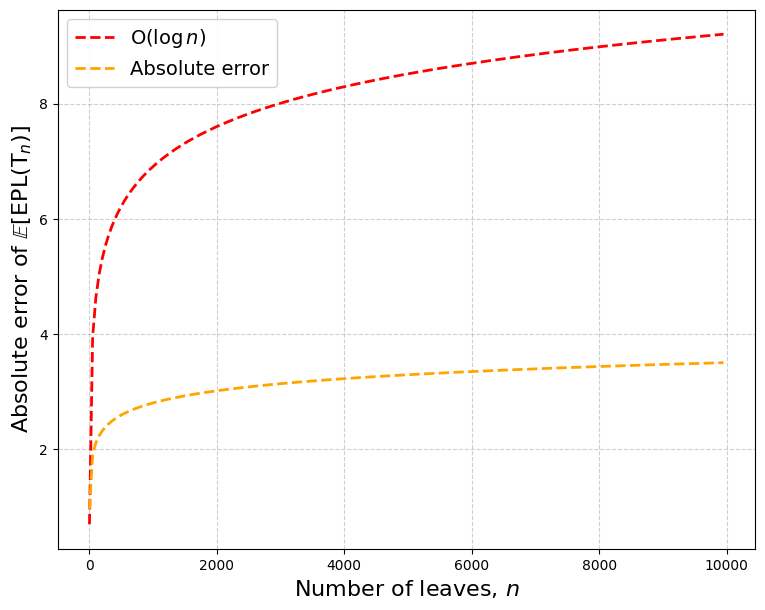

In [170]:
# Create the plot
fig, ax = plt.subplots(figsize=(9, 7))  # Larger figure size for readability

# Plot absolute error
ax.plot(Ns, np.log(Ns), label=r'$\mathrm{O}(\log n)$', linestyle='--', color='red', linewidth=2)
ax.plot(Ns, np.abs(epln_exacts - EEPLn(Ns)), label='Absolute error', linestyle='--', color='orange', linewidth=2)

# Title and axis labels
ax.set_xlabel(r'Number of leaves, $n$', fontsize=16)
ax.set_ylabel(r'Absolute error of $\mathbb{E}[\mathrm{EPL}(\mathrm{T}_n)]$', fontsize=16)

# Legend and grid
ax.legend(fontsize=14, frameon=True, framealpha=0.9)
ax.grid(visible=True, linestyle='--', alpha=0.6)

# Improve tick formatt0125ing
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', length=4)

# Show the plot
plt.show()

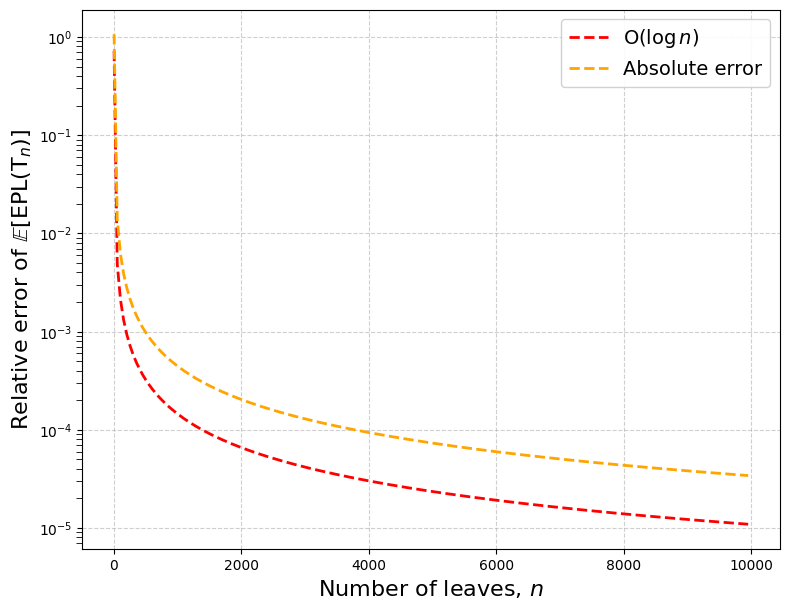

In [171]:
# Create the plot
fig, ax = plt.subplots(figsize=(9, 7))  # Larger figure size for readability

# Plot relative error
ax.plot(Ns, 1/(Ns * np.log(Ns)), label=r'$\mathrm{O}(\log n)$', linestyle='--', color='red', linewidth=2)
ax.plot(Ns, np.abs(epln_exacts - EEPLn(Ns)) / (A1 * EEPLn(Ns)), label='Absolute error', linestyle='--', color='orange', linewidth=2)

# Rescale y-axis
ax.set_yscale('log')

# Rescale y-axis
ax.set_yscale('log')

# Title and axis labels
ax.set_xlabel(r'Number of leaves, $n$', fontsize=16)
ax.set_ylabel(r'Relative error of $\mathbb{E}[\mathrm{EPL}(\mathrm{T}_n)]$', fontsize=16)

# Legend and grid
ax.legend(fontsize=14, frameon=True, framealpha=0.9)
ax.grid(visible=True, linestyle='--', alpha=0.6)

# Improve tick formatting
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', length=4)

# Show the plot
plt.show()

### Compute exact value of $\mathbb{E}[\mathrm{EPL}(\mathrm{T}_n)^2]$

In [172]:
zn_cache = {1: 0}

def exp_zn_exact(n):
    if n in zn_cache:
        return zn_cache[n]
    
    s1 = np.sum([(i-1)/(n-i)*exp_zn_exact(i) for i in range(1,n)])
    s2 = np.sum([exp_ln_exact(i)*exp_ln_exact(n-i) for i in range(1,n)])

    zn_cache[n] = 2*exp_ln_exact(n) - 1 + (s1+s2)/(n-1)/harmonic_number(n-1)
    return zn_cache[n]

ln2_cache = {1: 0}

def exp_ln2_exact(n):
    if n in ln2_cache:
        return ln2_cache[n]
    
    s = np.sum([exp_ln2_exact(i)/(n-i) for i in range(1,n)])

    ln2_cache[n] = 2*exp_ln_exact(n) - 1 + s/harmonic_number(n-1)
    return ln2_cache[n]

def exp_epln2_exact(n):
    return n*exp_ln2_exact(n) + n*(n-1)*exp_zn_exact(n)

In [173]:
epln2_exacts = []
for n_leaves in Ns:
    epln2_exacts.append(exp_epln2_exact(n_leaves))

### Second moment

In [174]:
A2 = 1 / (4 * zeta(2)**2)
B2 = (GAMMA * zeta(2) + zeta(3)) / (zeta(2)**3) 
C2 = -9/(10*zeta(2)) + (3*GAMMA**2 + 4*zeta(3))/(2*zeta(2)**2) + 3*GAMMA*zeta(3)/zeta(2)**3 + 2*zeta(3)**2/zeta(2)**4
D2 = 1 + (5*GAMMA**2 - 9*GAMMA - 20*zeta(3))/(5*zeta(2)) + (5*GAMMA**3 + 20*GAMMA*zeta(3) + 21*zeta(3) - 30*zeta(4))/(5*zeta(2)**2) + (3*GAMMA**2*zeta(3) + 4*zeta(3)**2)/(zeta(2)**3) + 4*GAMMA*zeta(3)**3/zeta(2)**4 + 2*zeta(3)**3/zeta(2)**5
EEPLn2 = lambda n: A2 * n**2 * np.log(n)**4 + B2 * n**2 * np.log(n)**3 + C2 * n**2 * np.log(n)**2 + D2 * n**2 * np.log(n)

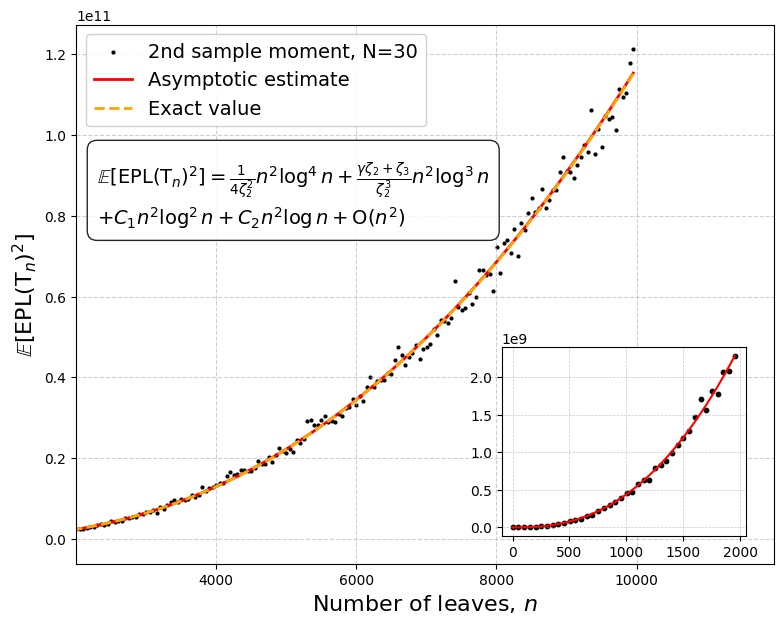

In [175]:
end = int(len(Ns)/5)

# Create the plot
fig, ax = plt.subplots(figsize=(9, 7))  # Larger figure size for readability

# Plot experimental and asymptotic estimates
ax.scatter(Ns, epl_mean2s, label=f'2nd sample moment, N={n_samples}', color='black', marker='o', s=4)
ax.plot(Ns, EEPLn2(Ns), label='Asymptotic estimate', linestyle='-', color='red', linewidth=2)
ax.plot(Ns, epln2_exacts, label='Exact value', linestyle='--', color='orange', linewidth=2)

ax.set_xlim([Ns[end], Ns[-1] + Ns[end]]) # shift plot to make room

# Title and axis labels
ax.set_xlabel(r'Number of leaves, $n$', fontsize=16)
ax.set_ylabel(r'$\mathbb{E}[\mathrm{EPL}(\mathrm{T}_n)^2]$', fontsize=16)

# Legend and grid
ax.legend(fontsize=14, loc='upper left', frameon=True, framealpha=0.9)
ax.grid(visible=True, linestyle='--', alpha=0.6)

# Textbox for the equation
equation_text = (
    r"$\mathbb{E}[\mathrm{EPL}(\mathrm{T}_n)^2] = \frac{1}{4\zeta_2^2} n^2 \log^4 n + \frac{\gamma\zeta_2 + \zeta_3}{\zeta_2^3} n^2 \log^3 n $" "\n"
    r"$+ C_1 n^2 \log^2 n + C_2 n^2 \log n + \mathrm{O}(n^2)$"
)
ax.text(
    2300, 0.85e11, equation_text, fontsize=14, va="center", ha="left",
    multialignment="left", 
    bbox=dict(
        facecolor="white", 
        edgecolor="black", 
        alpha=0.85, 
        boxstyle="round,pad=0.5"
    )
)

# Add inset plot
x_padding = 0.02  # Adjust x padding (fraction of the figure width)
y_padding = 0.04  # Adjust y padding (fraction of the figure height)
inset_ax = inset_axes(
    ax,
    width="35%", 
    height="35%",
    loc="lower right",
    borderpad=2
)

inset_ax.scatter(Ns[:end], epl_mean2s[:end], color='black', s=10)
inset_ax.plot(Ns[:end], EEPLn2(Ns[:end]), color='red', linewidth=1.5)

inset_ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Improve tick formatting
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', length=4)

# Show the plot
plt.show()

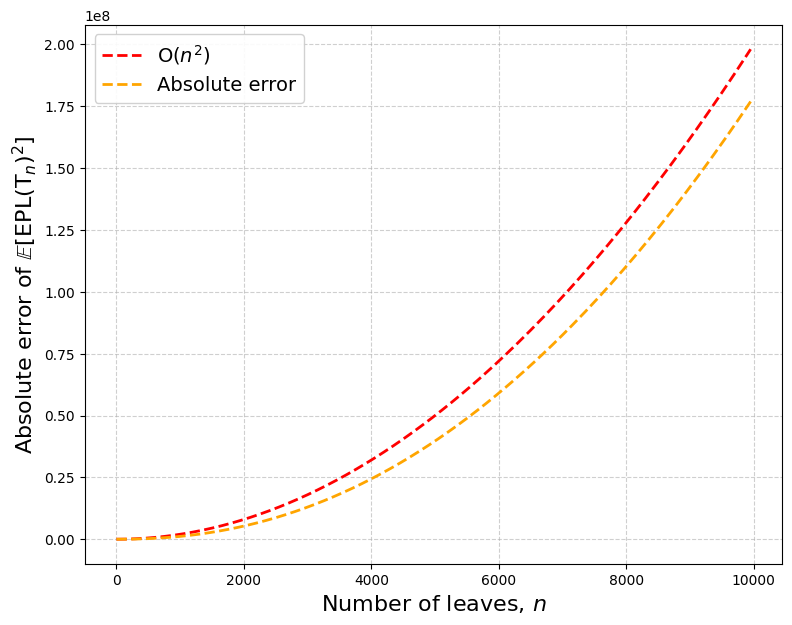

In [176]:
# Create the plot
fig, ax = plt.subplots(figsize=(9, 7))  # Larger figure size for readability

# Plot absolute error
ax.plot(Ns, 2*Ns**2, label=r'$\mathrm{O}(n^2)$', linestyle='--', color='red', linewidth=2)
ax.plot(Ns, np.abs(epln2_exacts - EEPLn2(Ns)), label='Absolute error', linestyle='--', color='orange', linewidth=2)

# Title and axis labels
ax.set_xlabel(r'Number of leaves, $n$', fontsize=16)
ax.set_ylabel(r'Absolute error of $\mathbb{E}[\mathrm{EPL}(\mathrm{T}_n)^2]$', fontsize=16)

# Legend and grid
ax.legend(fontsize=14, frameon=True, framealpha=0.9)
ax.grid(visible=True, linestyle='--', alpha=0.6)

# Improve tick formatt0125ing
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', length=4)

# Show the plot
plt.show()

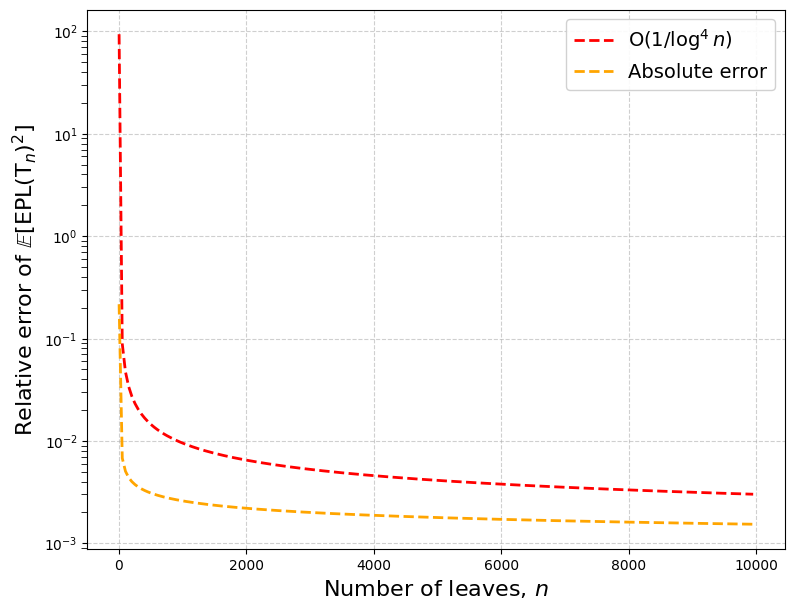

In [182]:
# Create the plot
fig, ax = plt.subplots(figsize=(9, 7))  # Larger figure size for readability

# Plot relative error
ax.plot(Ns, 2/(A2 * np.log(Ns)**4), label=r'$\mathrm{O}(1/\log^4 n)$', linestyle='--', color='red', linewidth=2)
ax.plot(Ns, np.abs(epln2_exacts - EEPLn2(Ns))/EEPLn2(Ns), label='Absolute error', linestyle='--', color='orange', linewidth=2)

# Rescalae y-axis
ax.set_yscale('log')

# Title and axis labels
ax.set_xlabel(r'Number of leaves, $n$', fontsize=16)
ax.set_ylabel(r'Relative error of $\mathbb{E}[\mathrm{EPL}(\mathrm{T}_n)^2]$', fontsize=16)

# Legend and grid
ax.legend(fontsize=14, frameon=True, framealpha=0.9)
ax.grid(visible=True, linestyle='--', alpha=0.6)

# Improve tick formatt0125ing
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', length=4)

# Show the plot
plt.show()

### Variance

In [178]:
var_exacts = epln2_exacts - epln_exacts**2

In [179]:
A3 = (2*zeta(3)/zeta(2)**2 - 1/zeta(2))
B3 = 1 + (GAMMA**2 - 2*GAMMA - 4*zeta(3))/zeta(2) + (4*zeta(3)*GAMMA + 4*zeta(3) - 6*zeta(4))/zeta(2)**2 + 4*zeta(3)**2/zeta(2)**3
VEPLn = lambda n: A3 * n**2 * np.log(n)**2 + B3 * n**2 * np.log(n)

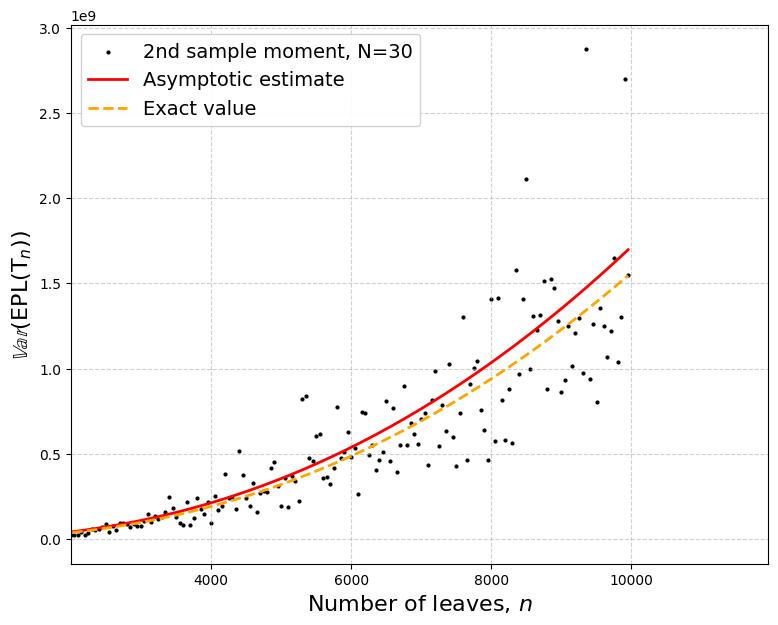

In [184]:
end = int(len(Ns)/5)

# Create the plot
fig, ax = plt.subplots(figsize=(9, 7))  # Larger figure size for readability

# Plot experimental and asymptotic estimates
ax.scatter(Ns, epl_vars, label=f'2nd sample moment, N={n_samples}', color='black', marker='o', s=4)
ax.plot(Ns, VEPLn(Ns), label='Asymptotic estimate', linestyle='-', color='red', linewidth=2)
ax.plot(Ns, var_exacts, label='Exact value', linestyle='--', color='orange', linewidth=2)

ax.set_xlim([Ns[end], Ns[-1] + Ns[end]]) # shift plot to make room

# Title and axis labels
ax.set_xlabel(r'Number of leaves, $n$', fontsize=16)
ax.set_ylabel(r'$\mathbb{Var}(\mathrm{EPL}(\mathrm{T}_n))$', fontsize=16)

# Legend and grid
ax.legend(fontsize=14, loc='upper left', frameon=True, framealpha=0.9)
ax.grid(visible=True, linestyle='--', alpha=0.6)

# Improve tick formatting
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', length=4)

# Show the plot
plt.show()

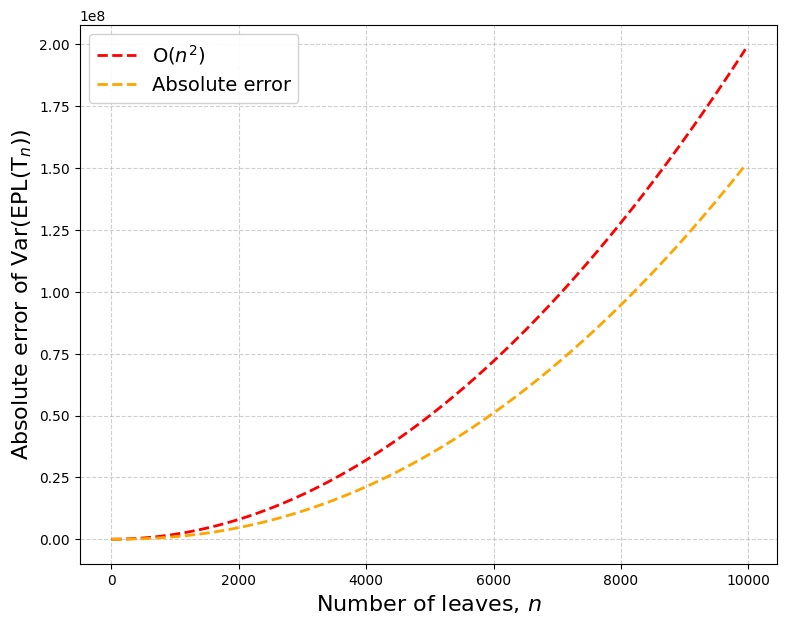

In [183]:
# Create the plot
fig, ax = plt.subplots(figsize=(9, 7))  # Larger figure size for readability

# Plot absolute error
ax.plot(Ns, 2*Ns**2, label=r'$\mathrm{O}(n^2)$', linestyle='--', color='red', linewidth=2)
ax.plot(Ns, np.abs(var_exacts - VEPLn(Ns)), label='Absolute error', linestyle='--', color='orange', linewidth=2)

# Title and axis labels
ax.set_xlabel(r'Number of leaves, $n$', fontsize=16)
ax.set_ylabel(r'Absolute error of $\mathrm{Var}(\mathrm{EPL}(\mathrm{T}_n))$', fontsize=16)

# Legend and grid
ax.legend(fontsize=14, frameon=True, framealpha=0.9)
ax.grid(visible=True, linestyle='--', alpha=0.6)

# Improve tick formatt0125ing
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', length=4)

# Show the plot
plt.show()